## Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
%config InlineBackend.figure_format = 'retina'

from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc, corpus2dense
from gensim.sklearn_api import TfIdfTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import os
import time

from jax import vmap, jit
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.nn import softmax

from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from imblearn.metrics import classification_report_imbalanced

In [2]:
data = pd.read_csv("/Users/jonny/Desktop/Dataset/Amazon Reviews/train_40k.csv").loc[:, ["Title", "Cat1", "Cat2"]]
data = data[~data.Title.isna()]

small_data = data.groupby('Cat2', group_keys=False).apply(lambda x: x.sample(min(len(x), 300), 
                                                                             random_state = 42)).reset_index(drop = True)
small_data.rename(columns = {"Cat1":"Parent Category", 
                             "Cat2":"Child Category"}).sample(2304).reset_index(drop = True).head(7)

# split into train and test: 
X_train, X_test, children_train, children_test = train_test_split(small_data.Title, small_data.Cat2, 
                                                    stratify = small_data.Cat2,
                                                    test_size=0.33, 
                                                    random_state=42)

test_ind = X_test.index
train_ind = X_train.index

parent_train = small_data.Cat1[train_ind]
parent_test = small_data.Cat1[test_ind]

# prob a better way to do this but i too tired
children_class_list = np.unique(children_train)
parent_class_list = np.unique(parent_train)
class_tree = {}
for c in small_data.Cat2.unique() :
    class_tree[c] = list(small_data.loc[small_data.Cat2 == c, "Cat1"])[0]

print("Number of primary cats: ", len(parent_train.value_counts()))
print("Number of subcats: ", len(children_test.value_counts()))

,Title,Parent Category,Child Category
0,Videonow Blue Player Headphone,toys games,electronics for kids
1,CRYPTIQUE Spirit Board Ouija Occult,toys games,games
2,"Andis 01690 Fade Master Clipper, Chrome",health personal care,personal care
3,"28"" Blazingly Fast Victory EP Racing RC Boat EP777",toys games,hobbies
4,Chomp Baby Pacifier,baby products,feeding
5,Cotton Candy Machine,toys games,dress up pretend play
6,"Fantastic 4 Movie Series II Deluxe 12"" Figure",toys games,action toy figures


Number of primary cats:  6
Number of subcats:  64


Use `Gensim` to find tf-idf scores for each title

In [3]:
%%time
# find tf-idf scores for training set

dct = Dictionary(X_train.map(lambda x: x.split(' ')))
dct.filter_extremes(no_below=5, no_above=0.7, keep_n = 2 ** 10)
dct.compactify()

train_corpus = [dct.doc2bow(doc.split(' ')) for doc in X_train]  # convert corpus to BoW format
tfidf_model = TfIdfTransformer()

train_tfidf = tfidf_model.fit_transform(train_corpus)
train_tfidf = corpus2dense(train_tfidf, num_terms = len(dct)) # can also use: corpus2csc
print(train_tfidf.shape)

test_corpus = [dct.doc2bow(doc.split(' ')) for doc in X_test] 
test_tfidf = corpus2dense(tfidf_model.transform(test_corpus), num_terms = len(dct))
print(test_tfidf.shape)

(1024, 9708)
(1024, 4782)
CPU times: user 913 ms, sys: 64.5 ms, total: 977 ms
Wall time: 977 ms


In [4]:
# Encode training labels for parent and children classes
# dist.Categorical returns numeric categories, not a 1-hot encoded vector
le = preprocessing.LabelEncoder()
parent_target = le.fit_transform(parent_train)
children_target = le.fit_transform(children_train)

parent_target_test = le.fit_transform(parent_test)
children_target_test = le.fit_transform(children_test)

lb = LabelBinarizer()
parent_binr = lb.fit_transform(parent_train)
children_binr = lb.fit_transform(children_train)

In [6]:
# helper function for HMC inference
def run_inference(model, rng_key, X, Y, num_warmup = 10, num_samples = 100, num_chains = 2):
    start = time.time()
    kernel = NUTS(model)
    print("Starting MCMC: ")
    mcmc = MCMC(kernel, num_warmup = num_warmup, 
                num_samples = num_samples, 
                num_chains = num_chains, 
                progress_bar = False)
    mcmc.run(rng_key, X, Y)
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc

# helper function for prediction
def predict(model, rng_key, samples, X):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None)
    return model_trace['Y']['value']

# Parent Posterior as Child Prior

In [71]:
def parent_model(X, Y=None):
#     print("hello")
    if Y == None : 
        dim_Y = 6
    else :
        dim_Y = Y.shape[1]
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros((X.shape[1], dim_Y)), jnp.ones((X.shape[1], dim_Y))*2)) 
    err = numpyro.sample("err", dist.Normal(0., 1.))
    resp = jnp.matmul(X, beta) + err
    probs = softmax(resp) # jax softmax, not scipy
#     print("X shape: ", X.shape)
#     print("beta shape: ", beta.shape)
#     print("resp shape: ", resp.shape)
#     print("Y shape: ", Y.shape)
#     numpyro.sample('Y', dist.Categorical(probs = probs), obs=Y)
    numpyro.sample("Y", dist.Multinomial(probs = probs), obs = Y)

In [72]:
X = jnp.asarray(train_tfidf.T, dtype = "float32")
Y = jnp.asarray(parent_binr, dtype = "float32") # binarized labels

_num_chains = 4
_num_samples = 200
numpyro.set_host_device_count(_num_chains)
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
mcmc = run_inference(model = parent_model, 
                     rng_key = rng_key, 
                     X = X, Y = Y,
                     num_warmup = 50, 
                     num_samples = _num_samples, 
                     num_chains = _num_chains)
parent_samples = mcmc.get_samples()
print("MCMC complete")

Starting MCMC: 

MCMC elapsed time: 7.122047185897827
MCMC complete


In [73]:
%%time
# predict Y_test at inputs X_test
vmap_args = (parent_samples, random.split(rng_key_predict, _num_chains * _num_samples))
predictions = vmap(lambda samples, rng_key: predict(parent_model, rng_key, samples, X))(*vmap_args)

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

class_predictions = pd.DataFrame(mean_prediction).apply(np.argmax, axis = 1)
print("Training set accuracy: ", np.mean(class_predictions == parent_target))

Training set accuracy:  0.8685620107128141
CPU times: user 45min 36s, sys: 18.6 s, total: 45min 54s
Wall time: 7min 20s


In [74]:
test_predictions = vmap(lambda samples, rng_key: predict(parent_model, rng_key, samples, test_tfidf.T))(*vmap_args)

mean_test_prediction = jnp.mean(test_predictions, axis=0)

test_class_predictions = pd.DataFrame(mean_test_prediction).apply(np.argmax, axis = 1)
print("Test set accuracy: ", np.mean(test_class_predictions == parent_target_test))

Test set accuracy:  0.8103304056879966


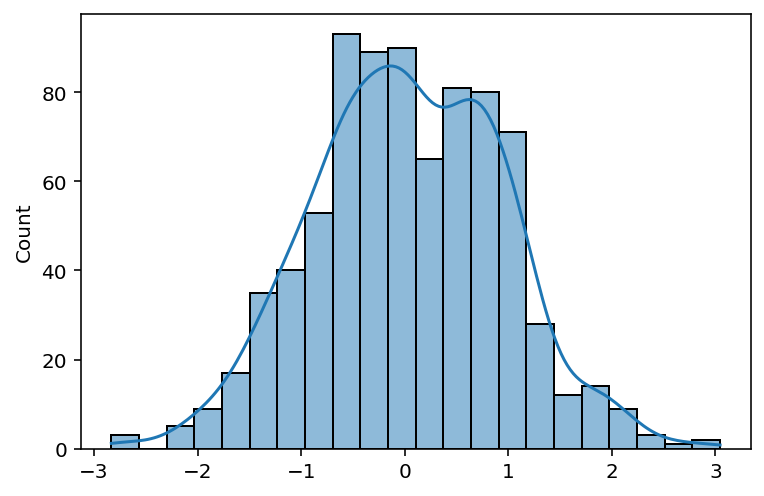

In [75]:
sns.histplot(mcmc.get_samples()["err"], kde = True);

Use Posterior Mean as Prior Mean

In [77]:
# use the posterior of the parent regression as the prior mean for the child regression
beta_posterior = parent_samples["beta"]
posterior_mean = np.apply_along_axis(np.mean, 0, beta_posterior)

posterior_mean_df = pd.DataFrame(posterior_mean, columns = parent_class_list)

prior_mean = pd.DataFrame()
for c in children_class_list :
    prior_mean[c] = posterior_mean_df[class_tree[c]]
    
prior_mean.head()

,action toy figures,arts crafts,baby child care,baby food,baby toddler toys,bath body,bathing skin care,beverages,birds,breads bakery,...,sexual wellness,skin care,small animals,snack food,sports outdoor play,strollers,stuffed animals plush,tools accessories,tricycles,vehicles remote control
0,1.189016,1.189016,1.258788,-0.094080,1.189016,0.283161,-1.615682,-0.094080,-1.298441,-0.094080,...,1.258788,0.283161,-1.298441,-0.094080,1.189016,-1.615682,1.189016,0.283161,1.189016,1.189016
1,-1.127307,-1.127307,0.311698,-1.267747,-1.127307,2.672709,0.245926,-1.267747,-1.029399,-1.267747,...,0.311698,2.672709,-1.029399,-1.267747,-1.127307,0.245926,-1.127307,2.672709,-1.127307,-1.127307
2,1.112809,1.112809,0.752100,-1.578035,1.112809,-0.089645,-0.105106,-1.578035,0.341998,-1.578035,...,0.752100,-0.089645,0.341998,-1.578035,1.112809,-0.105106,1.112809,-0.089645,1.112809,1.112809
3,0.695724,0.695724,0.157758,-0.393810,0.695724,0.789911,-0.236455,-0.393810,-0.891724,-0.393810,...,0.157758,0.789911,-0.891724,-0.393810,0.695724,-0.236455,0.695724,0.789911,0.695724,0.695724
4,2.937419,2.937419,0.071968,-1.379720,2.937419,-1.184570,0.890030,-1.379720,-1.464024,-1.379720,...,0.071968,-1.184570,-1.464024,-1.379720,2.937419,0.890030,2.937419,-1.184570,2.937419,2.937419


In [78]:
# model for the child classes
def child_model(X, Y=None):
#     print("hello")
    beta = numpyro.sample("beta", dist.Normal(jnp_prior_mean, jnp.ones(jnp_prior_mean.shape)*2))
    err = numpyro.sample("err", dist.Normal(0., 0.5))
    resp = jnp.matmul(X, beta) + err
    probs = softmax(resp) # jax softmax, not scipy
#     print("X shape: ", X.shape)
#     print("beta shape: ", beta.shape)
#     print("resp shape: ", resp.shape)
#     print("Y shape: ", Y.shape)
    numpyro.sample("Y", dist.Multinomial(probs = probs), obs = Y)

In [79]:
X = jnp.asarray(train_tfidf.T, dtype = "float32")
Y = jnp.asarray(children_binr, dtype = "float32") # binarized labels
jnp_prior_mean = jnp.asarray(prior_mean, dtype = "float32")

_num_chains = 4
_num_samples = 200
numpyro.set_host_device_count(_num_chains)
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

child_model_reparam = reparam(child_model, config={'beta': LocScaleReparam(0)})

child_mcmc = run_inference(model = child_model_reparam, 
                           rng_key = rng_key, 
                           X = X, Y = Y,
                           num_warmup = 50, 
                           num_samples = _num_samples, 
                           num_chains = _num_chains)
child_samples = child_mcmc.get_samples()
print("MCMC complete")

Starting MCMC: 


/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/numpyro/infer/mcmc.py:483: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(4)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))



MCMC elapsed time: 7.060860872268677
MCMC complete


In [335]:
%%time
# predict Y_test at inputs X_test
vmap_args = (child_samples, random.split(rng_key_predict, _num_chains * _num_samples))
children_predictions = vmap(lambda samples, rng_key: predict(child_model, rng_key, samples, X))(*vmap_args)

# compute mean prediction and confidence interval around median
mean_children_prediction = jnp.mean(children_predictions, axis=0)
percentiles = np.percentile(children_predictions, [5.0, 95.0], axis=0)

child_class_predictions = pd.DataFrame(mean_children_prediction).apply(np.argmax, axis = 1)
print("Train set accuracy, child categories: ", np.mean(child_class_predictions == children_target))

Train set accuracy, child categories:  0.5079316028018129


In [336]:
%%time
child_test_predictions = vmap(lambda samples, rng_key: predict(child_model, rng_key, samples, test_tfidf.T))(*vmap_args)

mean_child_test_prediction = jnp.mean(child_test_predictions, axis=0)

test_child_class_predictions = pd.DataFrame(mean_child_test_prediction).apply(np.argmax, axis = 1)
print("Test set accuracy, child categories: ", np.mean(test_child_class_predictions == children_target_test))

Test set accuracy, child categories:  0.4374738603094939
CPU times: user 27.6 s, sys: 14.3 s, total: 41.9 s
Wall time: 16 s


### Flat Classification

Flatten out the hierarchy and fit a classification model to the classes. Compare results, especially for low data classes

In [18]:
ridge_clf = RidgeClassifier().fit(train_tfidf.T, children_target)
print("Ridge classifier train set accuracy, children classes: ", ridge_clf.score(train_tfidf.T, children_target))
print("Ridge classifier test set accuracy, children classes: ", ridge_clf.score(test_tfidf.T, children_target_test))

print('')

# linear SVM
sgd_clf = SGDClassifier(loss = "hinge", # linear SVM, "log" for logistic regression
                        max_iter=1000, 
                        n_jobs = -1, 
                        random_state = 42,
                        tol=1e-3).fit(train_tfidf.T, children_target)
print("SVM classifier train set accuracy, children classes: ", sgd_clf.score(train_tfidf.T, children_target))
print("SVM classifier test set accuracy, children classes: ", sgd_clf.score(test_tfidf.T, children_target_test))

print('')

# logistic regression
log_reg = SGDClassifier(loss = "log", # linear SVM, "log" for logistic regression
                        max_iter=1000, 
                        n_jobs = -1, 
                        random_state = 42,
                        tol=1e-3).fit(train_tfidf.T, children_target)
# log_reg.predict_proba(test_tfidf.T)
print("Logistic Regression train set accuracy, children classes: ", log_reg.score(train_tfidf.T, children_target))
print("Logistic Regression test set accuracy, children classes: ", log_reg.score(test_tfidf.T, children_target_test))
log_reg_predictions = le.inverse_transform(log_reg.predict(test_tfidf.T))

Ridge classifier train set accuracy, children classes:  0.7184796044499382
Ridge classifier test set accuracy, children classes:  0.6273525721455459

SVM classifier train set accuracy, children classes:  0.7481458590852905
SVM classifier test set accuracy, children classes:  0.6288163948138854

Logistic Regression train set accuracy, children classes:  0.7081788215904409
Logistic Regression test set accuracy, children classes:  0.6286072772898369


# Non-Centered Hiearchical Model 

Take a less explicit approach to modelling the hierarchical structure by using 1 model. 

In [7]:
# make a matrix that we can use to multiply against `posterior_mean` in order to get `prior_mean`
alpha = np.zeros((len(parent_class_list), len(children_class_list)))

for i, c in enumerate(children_class_list) :
    alpha[:, i] = parent_class_list == class_tree[c]
# prior_mean2 = jnp.matmul(posterior_mean, alpha)

In [15]:
# non-centered hierarchical model
def hierarchical_model (X, Y=None, _num_parent_classes = 6, _alpha = alpha):
#     print("hello")
    dim_X = X.shape[1]
    # hierarchical prior: beta_0 ~ N(0, 1) 
    beta_0 = numpyro.sample("beta_0", dist.Normal(jnp.zeros((dim_X, np.array([_num_parent_classes])[0])), 
                                                  jnp.ones((dim_X, np.array([_num_parent_classes])[0]))))

    # construct prior for $\beta$ by multiplying with \alpha 
    jnp_prior_mean = jnp.matmul(beta_0, _alpha)

    # now we can sample beta        
    beta = numpyro.sample("beta", dist.Normal(jnp_prior_mean, jnp.ones(jnp_prior_mean.shape)))
    err = numpyro.sample("err", dist.Normal(0., 0.5))
    resp = jnp.matmul(X, beta) + err
    probs = softmax(resp) 
#     print("X shape: ", X.shape)
#     print("beta shape: ", beta.shape)
#     print("Y shape: ", Y.shape)
    numpyro.sample("Y", dist.Multinomial(probs = probs), obs = Y)

In [16]:
num_parent_classes = len(parent_class_list)
X = jnp.asarray(train_tfidf.T, dtype = "float32")
Y = jnp.asarray(children_binr, dtype = "float32") # binarized labels

_num_chains = 4
_num_samples = 500
numpyro.set_host_device_count(_num_chains)
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

reparam_model = reparam(hierarchical_model, config={'beta': LocScaleReparam(0)})

non_centered_mcmc = run_inference(model = reparam_model, 
                           rng_key = rng_key, 
                           X = X, Y = Y, 
                           num_warmup = 50, 
                           num_samples = _num_samples, 
                           num_chains = _num_chains)
nc_samples = non_centered_mcmc.get_samples()
print("MCMC complete")

Starting MCMC: 

MCMC elapsed time: 8.706219911575317
MCMC complete


In [ ]:
%%time
# predict Y_test at inputs X_test
vmap_args = (nc_samples, random.split(rng_key_predict, _num_chains * _num_samples))
children_predictions = vmap(lambda samples, rng_key: predict(reparam_model, rng_key, samples, X))(*vmap_args)

# compute mean prediction and confidence interval around median
mean_children_prediction = jnp.mean(children_predictions, axis=0)
percentiles = np.percentile(children_predictions, [5.0, 95.0], axis=0)

child_class_predictions = pd.DataFrame(mean_children_prediction).apply(np.argmax, axis = 1)
print("Train set accuracy, child categories: ", np.mean(child_class_predictions == children_target))

In [15]:
%%time
child_test_predictions = vmap(lambda samples, rng_key: predict(reparam_model, rng_key, samples, test_tfidf.T))(*vmap_args)

mean_child_test_prediction = jnp.mean(child_test_predictions, axis=0)

test_child_class_predictions = pd.DataFrame(mean_child_test_prediction).apply(np.argmax, axis = 1)
print("Test set accuracy, child categories: ", np.mean(test_child_class_predictions == children_target_test))

Test set accuracy, child categories:  0.6277708071936429
CPU times: user 21.3 s, sys: 5.01 s, total: 26.3 s
Wall time: 7.43 s


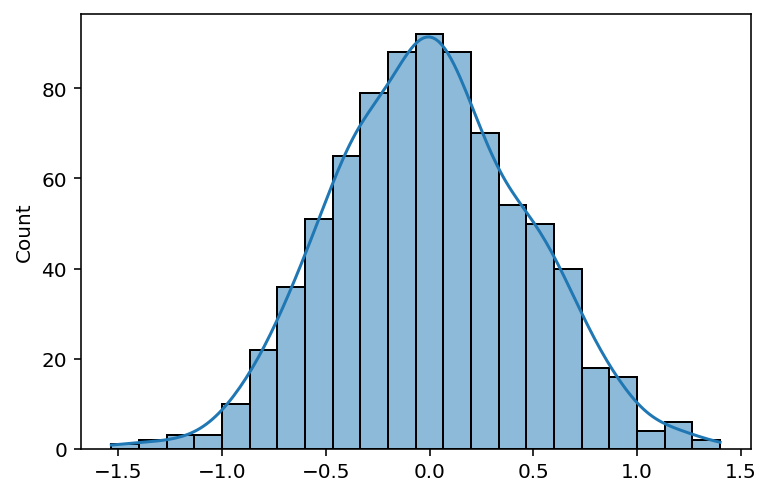

In [40]:
sns.histplot(nc_samples["err"], kde = True);

## Compare Classifiers

When comparing classifiers, consider out-of-distribution examples as well as the performance of low-data classes.

Have to also compare the parent categories. This is where the hierarchical model should come out on top

In [107]:
from sklearn.metrics import precision_score, recall_score

In [113]:
chilren_test_predictions = le.inverse_transform(test_child_class_predictions)

low_data_classes = list(children_train.value_counts().index[children_train.value_counts() < 30])

list(zip(low_data_classes, precision_score(y_true = children_test, y_pred = chilren_test_predictions, 
                                average=None, labels = low_data_classes, zero_division = 0)))

list(zip(low_data_classes, recall_score(y_true = children_test, y_pred = chilren_test_predictions, 
                                average=None, labels = low_data_classes, zero_division = 0)))

[('meat poultry', 0.4117647058823529),
 ('baby food', 0.3076923076923077),
 ('sauces dips', 0.16666666666666666),
 ('produce', 0.5833333333333334),
 ('meat seafood', 0.0),
 ('small animals', 0.0)]

[('meat poultry', 0.5),
 ('baby food', 0.3076923076923077),
 ('sauces dips', 0.15384615384615385),
 ('produce', 0.5833333333333334),
 ('meat seafood', 0.0),
 ('small animals', 0.0)]

In [124]:
# parent category accuracy:

print("Hierarchical model parent accuracy: ", np.mean(parent_test == list(map(lambda x: class_tree[x], chilren_test_predictions))))

print(' ')

print("Logistic regression parent accuracy: ", 
      np.mean(parent_test == list(map(lambda x: class_tree[x], log_reg_predictions))))

Hierarchical model parent accuracy:  0.8086574654956086
 
Logistic regression parent accuracy:  0.8115851108322878


In [125]:
print(classification_report_imbalanced(y_true = children_target_test, 
                                       y_pred = test_child_class_predictions,
                                       target_names = children_class_list))

# logistic regression classification metrics:
print(classification_report_imbalanced(y_true = children_target_test, 
                                       y_pred = log_reg.predict(test_tfidf.T),
                                       target_names = children_class_list))

### Graphviz Representation

http://magjac.com/graphviz-visual-editor/

In [39]:
td = {}
for k in class_tree.keys() :
    if class_tree[k] not in td :
        td[class_tree[k]] = [k]
    elif len(td[class_tree[k]]) < 5 : 
        td[class_tree[k]].append(k)

print ("digraph G {\nrankdir=LR;")
n = 0
lookup = {}
for root in td.keys():
    if not (root in lookup):
        lookup[root] = n
        print ('n%d [label="%s" fontsize=18 width=0.5];' % (n,root))
        n += 1
    for leaf in td[root]:
        if not (leaf in lookup):
            lookup[leaf] = n
            print ('n%d [label="%s"];' % (n,leaf))
            n += 1
        print ('n%d -> n%d;' % (lookup[root],lookup[leaf]))

print ("}")